In [83]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

https://github.com/mcsiple/tidytuesday/blob/master/2021/5_2021_plastics.R

https://raw.githubusercontent.com/mcsiple/tidytuesday/master/2021/5_2021_plastics.png

https://github.com/rfordatascience/tidytuesday/blob/master/data/2021/2021-01-26/readme.md

In [2]:
path = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-01-26/plastics.csv"
data = pd.read_csv(path)

In [3]:
types_of_plastic = ["empty", "hdpe", "ldpe", "o", "pet", "pp", "ps", "pvc"]
total_by_company = (
    data
    .groupby(["parent_company", "year"], dropna=True)[types_of_plastic]
    .sum()
    .reset_index()
)
total_by_company

,parent_company,year,empty,hdpe,ldpe,o,pet,pp,ps,pvc
0,"""ESE""",2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"""Inko"" noodles / Ð®Ñ„ÐºÐ° â€œÐ˜Ð½ÐºÐ¾""",2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"""Мелочи Жизни"" (Ооо Ергопак)",2019,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
3,#ERROR!,2020,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0
4,(Local Factory),2020,0.0,0.0,0.0,0.0,9.0,20.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
11215,Ямуна,2019,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
11216,Янтар,2019,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
11217,Янтар (Сан Інбев Україна),2019,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
11218,Янтарь,2019,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [17]:
def get_top_n_data(data, n):
    top_data = (
        data
        .query("year == 2020")
        .melt(id_vars=["parent_company", "year"], value_vars=types_of_plastic, var_name="type")
        .groupby("parent_company")["value"]
        .sum()
        .reset_index()
    )

    top_data["parent_company"] = np.where(
    top_data["parent_company"].isin(["Unbranded", "null", "NULL", "#ERROR!"]), 
        "Unbranded_unknown",
        top_data["parent_company"]
    )

    top_companies = list(top_data.sort_values("value", ascending=False)["parent_company"][:n])

    top_data["company_lumped"] = np.where(
        top_data["parent_company"].isin(top_companies),
        top_data["parent_company"],
        "Other"
    )

    top_data = top_data.drop_duplicates(["parent_company", "company_lumped"])
    top_data = top_data.merge(total_by_company, on="parent_company")

    # All types of plastic except from 'empty'
    top_data["total"] = top_data.loc[:, types_of_plastic[1:]].sum(axis=1)

    return top_data

In [18]:
top_seven = get_top_n_data(total_by_company, n = 7)
top_thirty = get_top_n_data(total_by_company, n = 30)

In [19]:
# Top 6 companies palettes, from design-seeds.com
COMPANY_PALETTES = ["#81C4CA", "#468D96", "#103128", "#E83D5F", "#FA6E90", "#FCB16D"]

In [48]:
top_thirty_2 = (
    top_thirty
    .groupby("company_lumped")[types_of_plastic]
    .sum()
    .reset_index()
)

# This time we keep the 'empty' plastcis
top_thirty_2["row_sum"] = top_thirty_2.loc[:, types_of_plastic].sum(axis=1)

top_thirty_2[types_of_plastic] = top_thirty_2[types_of_plastic].apply(lambda x: x / top_thirty_2["row_sum"])
top_thirty_2 = top_thirty_2.drop(columns="row_sum")


top_thirty_2 = top_thirty_2.melt(
    id_vars="company_lumped",  
    value_vars=types_of_plastic,
    var_name="type",
    value_name="proportion"

)
top_thirty_2.head()

,company_lumped,type,proportion
0,Bakhresa Group,empty,0.000000
1,Blow-Chem Industries,empty,0.000000
2,Britannia,empty,0.000000
3,Colgate-Palmolive,empty,0.000611
4,Cway Group,empty,0.000000


In [68]:
sorted_categories = list(top_thirty_2["company_lumped"].unique())
sorted_categories = sorted(sorted_categories, key=str.lower)
sorted_categories.remove("Other")
sorted_categories += ["Other"]

In [80]:
top_thirty_2["company_lumped"] = pd.Categorical(
    top_thirty_2["company_lumped"], 
    categories=sorted_categories, 
    ordered=True
)

top_thirty_2 = top_thirty_2.sort_values("company_lumped", ascending=False)

In [103]:
COLORS = ["#FFFFCC", "#C7E9B4", "#7FCDBB", "#41B6C4", "#1D91C0", "#225EA8", "#0C2C84"]
COLORS.reverse()

# Colormap
cmap = mcolors.LinearSegmentedColormap.from_list("my color", COLORS, N=256)

In [102]:
COLORS.reverse()

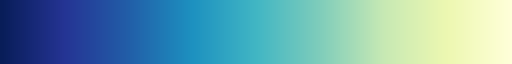

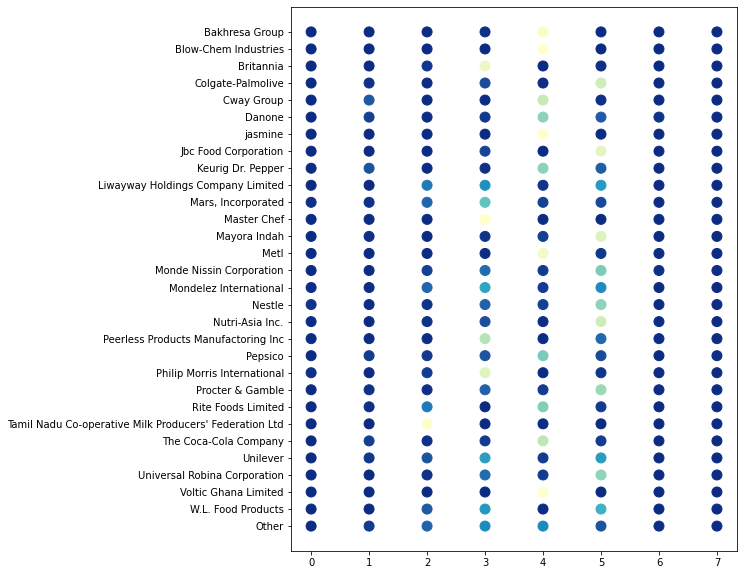

In [104]:
fig, ax = plt.subplots(figsize = (8, 10))

for i, plastic in enumerate(types_of_plastic):
    d = top_thirty_2[top_thirty_2["type"] == plastic]
    y = d["company_lumped"]

    # No need to normalize since proportions are between 0 and 1
    colors = cmap(d["proportion"])

    ax.scatter([i] * len(y), d["company_lumped"], color=colors, s=100)

For the extra mile section:

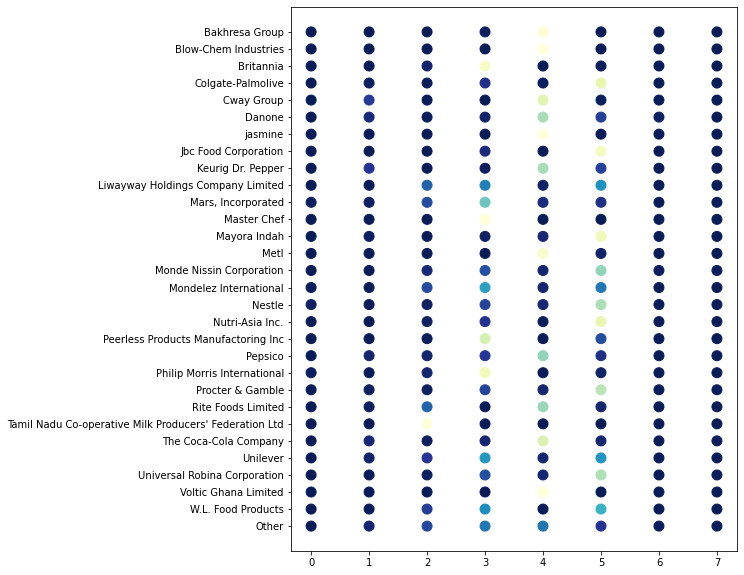

In [106]:
cmap = plt.get_cmap("YlGnBu")
cmap = cmap.reversed()
cmap

Fig, ax = plt.subplots(figsize = (8, 10))

for i, plastic in enumerate(types_of_plastic):
    d = top_thirty_2[top_thirty_2["type"] == plastic]
    y = d["company_lumped"]

    # No need to normalize since proportions are between 0 and 1
    colors = cmap(d["proportion"])

    ax.scatter([i] * len(y), d["company_lumped"], color=colors, s=100)